In [19]:
from collections import namedtuple, Counter
import gzip
import random
import subprocess
import itertools

import pandas as pd
import numpy as np
import scipy
import librosa
import librosa.display

import requests
import json
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
# import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [20]:
def construct_preview(track_uri):
    # extract preview for track
    track_id = track_uri.split("track:")[1]
    today = datetime.now().date() - timedelta(days=1)

    url = "http://acdc-solr:8983/solr/track_" + today.strftime('%Y%m%d') + "/select?fl=audio_preview&q=track_id:" + track_id
    meta = json.loads(requests.get(url).text)
    audio_preview = meta['response']['docs'][0]['audio_preview']
    audio_preview_url = "https://p.scdn.co/mp3-preview/" + audio_preview
    return audio_preview_url

## extract preview for track

In [21]:
mp3_preview = construct_preview("spotify:track:21YnmkSDhUkmkkni22Svc4")
display(mp3_preview)
!curl -o tmp.mp3 $mp3_preview

'https://p.scdn.co/mp3-preview/0c4f3e18f16a4be7fa181f9eae249a18f7db5099'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  352k  100  352k    0     0   352k      0  0:00:01 --:--:--  0:00:01  681k


## sampling & spectrogram

In [22]:
!ffmpeg -y -i tmp.mp3 -f s16le -acodec pcm_s16le -ar 44100 -ac 1 tmp.pcm
# pcm_s16le: PCM signed 16-bit little-endian; PCM: Pulse Code Modulation

ffmpeg version 4.0 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.0.0 (clang-900.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mp3, from 'tmp.mp3':
  Duration: 00:00:30.04, start: 0.025057, bitrate: 96 kb/s
    Stream #0:0: Audio: mp3, 44100 Hz, stereo, fltp, 96 kb/s
    Metadata:
      encoder         : LAME3

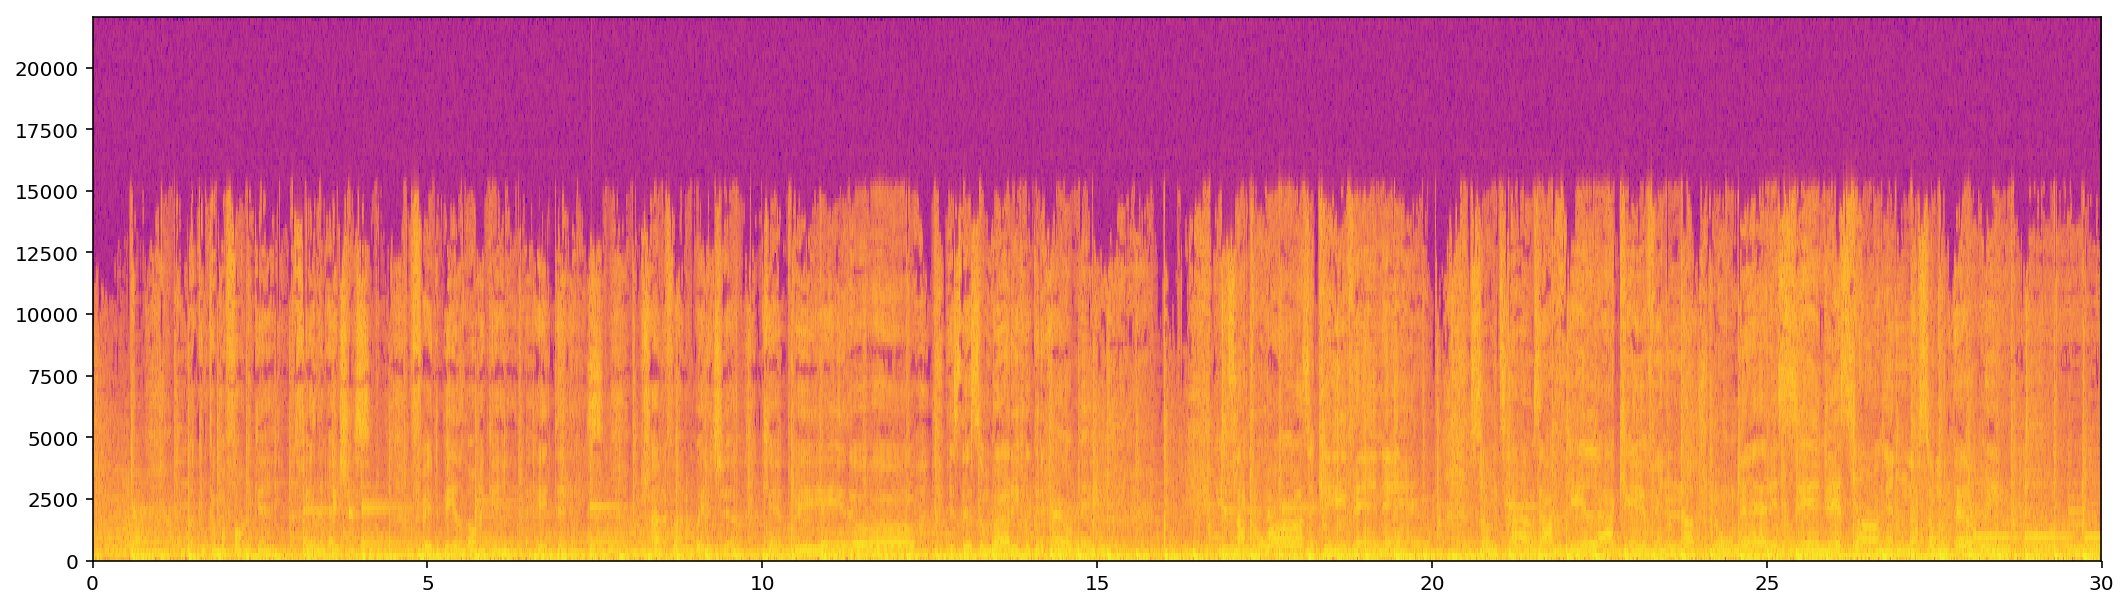

In [23]:
s = np.fromfile('tmp.pcm', dtype="int16")
plt.specgram(s, Fs=44100, cmap='plasma')
fig = plt.gcf()  # get a reference to the current figure
fig.set_size_inches(18, 5)

In [24]:
!ffmpeg -y -i tmp.mp3 -acodec pcm_u8 -ar 44100 tmp.wav  # compressed .mp3 file; uncompressed .wav file
# sampling rate: 44100 samples per second per channel
# stereo (two channels) vs mono (one channel)

# Nyquist–Shannon sampling theorem: To be exact, we need to sample twice as frequently 
# as the frequency we want to see to make sure we’re detecting it.

# In the case of recording audio, the accepted rule is that we’re OK missing out on frequencies 
# above 22050 Hz since humans can’t even hear frequencies above 20,000 Hz.

# The MP3 format compresses this in order to 1) save space on your hard drive, 
# and 2) irritate audiophiles, but a pure .wav formatted file on your computer is 
# just a list of 16 bit integers (with a small header).

# pcm_u8: PCM unsigned 8-bit

ffmpeg version 4.0 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.0.0 (clang-900.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, mp3, from 'tmp.mp3':
  Duration: 00:00:30.04, start: 0.025057, bitrate: 96 kb/s
    Stream #0:0: Audio: mp3, 44100 Hz, stereo, fltp, 96 kb/s
    Metadata:
      encoder         : LAME3

## Mel spectrogram

/Users/xuechen/miniconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


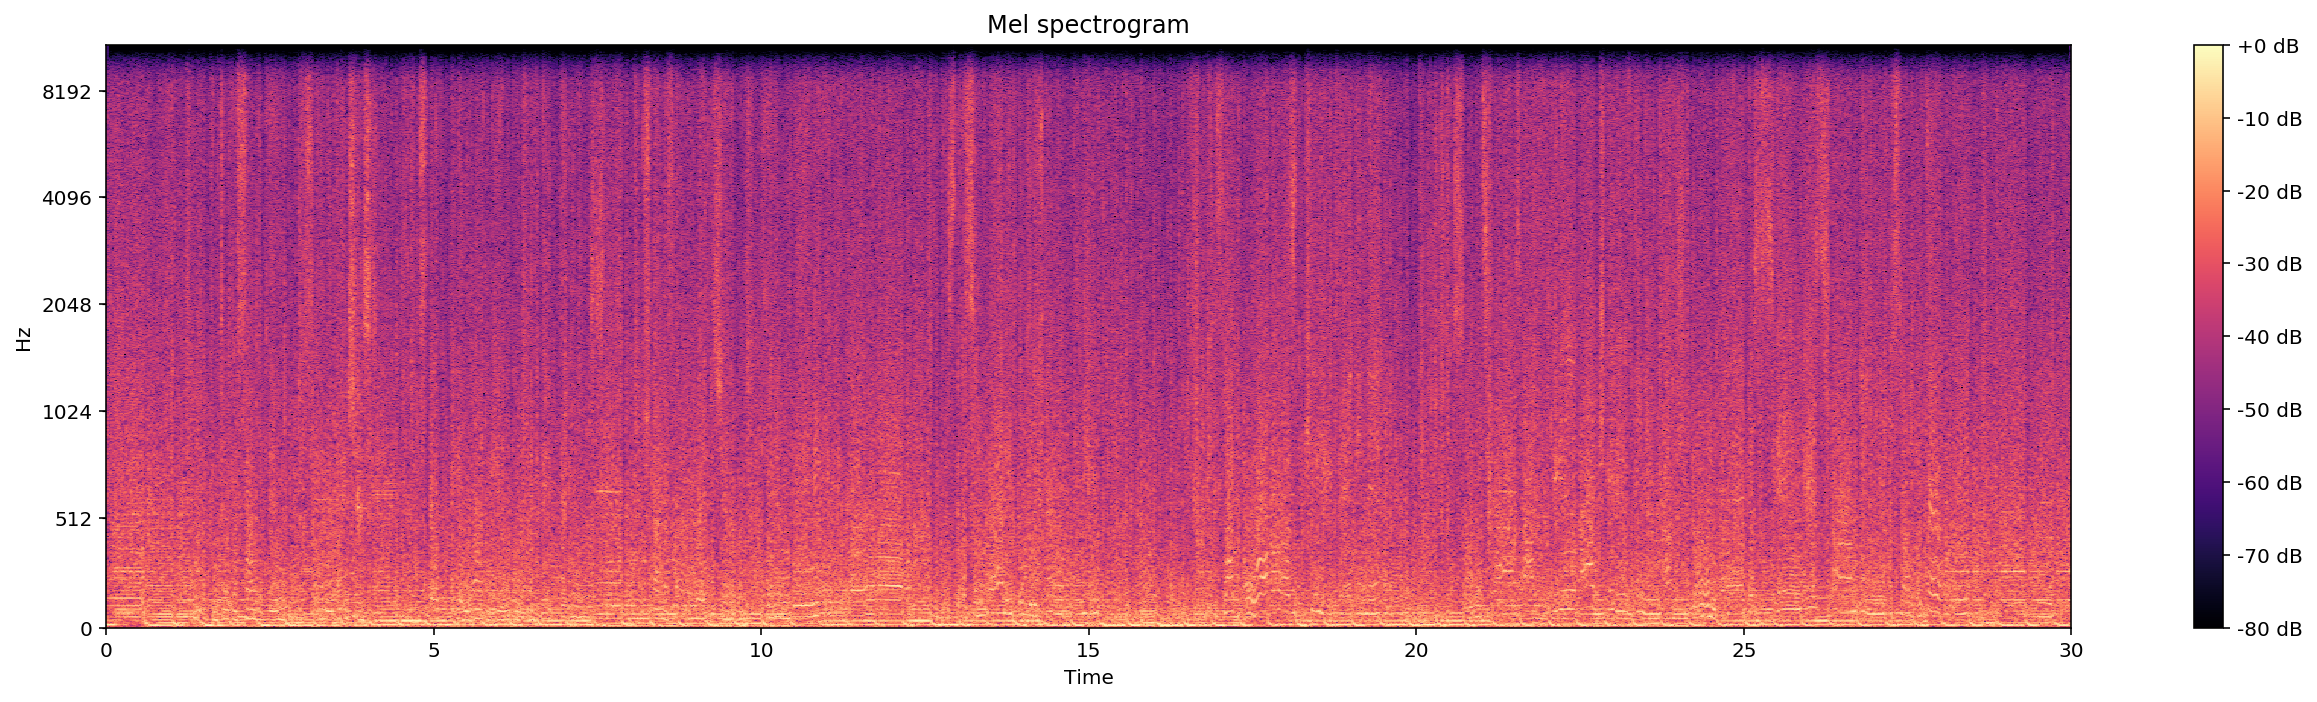

In [28]:
y, sr = librosa.load('tmp.wav')
plt.figure(figsize=(18, 5))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)       # Short-Time Fourier Transform
librosa.display.specshow(D, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()